# Sentiment Analysis 
<img src="sent.jpg" width="500"/> 



Hi 🙂, if you are seeing this notebook, you've succesfully started your first project on Iventura, hooray! 🚀


[sentiment analsysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is one of the most common [NLP](https://en.wikipedia.org/wiki/Natural_language_processing) problems. The goal is to analyze a text and predict whether the underlying sentiment is positive, negative or neutral. You can get sentiment on supervised dataset or un supervised dataset.Here are few ideas to use sentiment on measure sentiment of customer support tickets, survey responses, social media, and movie reviews,customer reviews for any ecommerce website!📖

 

# Sentiment Analysis for drugs/medicines💊
 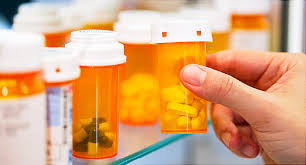   

## Problem Statement
***Nowadays the narrative of a brand is not only built and controlled by the company that owns the brand. For this reason, companies are constantly looking out across Blogs, Forums, and other social media platforms, etc for checking the sentiment for their various products and also competitor products to learn how their brand resonates in the market. This kind of analysis helps them as part of their post-launch market research. This is relevant for a lot of industries including pharma and their drugs.***
 

***The challenge is that the language used in this type of content is not strictly grammatically correct. Some use sarcasm. Others cover several topics with different sentiments in one post. Other users post comments and reply and thereby indicating his/her sentiment around the topic***

##### Sentiment can be clubbed into 3 major buckets - Positive, Negative and Neutral Sentiments.

Data contain samples of text. This text can contain one or more drug mentions. Each row contains a unique combination of the text and the drug mention. Note that the same text can also have different sentiment for a different drug.
# Objective:
**Given the text and drug name, the task is to predict the sentiment for texts contained in the test dataset.**

Given below is an example of text from the dataset:


**Example:**

**Stelara is still fairly new to Crohn's treatment. This is why you might not get a lot of replies. I've done some research, but most of the "time to work" answers are from Psoriasis boards. For Psoriasis, it seems to be about 4-12 weeks to reach a strong therapeutic level. The good news is, Stelara seems to be getting rave reviews from Crohn's patients. It seems to be the best med to come along since Remicade. I hope you have good success with it. My daughter was diagnosed Feb. 19/07, (13 yrs. old at the time of diagnosis), with Crohn's of the Terminal Illium. Has used Prednisone and Pentasa. Started Imuran (02/09), had an abdominal abscess (12/08). 2cm of Stricture. Started ​Remicade in Feb. 2014, along with 100mgs. of Imuran.**

 

**For Stelara the above text is ​positive​ while for Remicade the above text is ​negative​.**

 

# Data Description
train.csv
Contains the labelled texts with sentiment values for a given drug
 

Variable	Definition
unique_hash	Unique ID
text	text pertaining to the drugs
drug	drug name for which the sentiment is provided
sentiment	(Target) 0-positive, 1-negative, 2-neutral

# test.csv
test.csv contains texts with drug names for which the participants are expected to predict the correct sentiment
 

sample_submission.csv
sample_submission.csv contains the submission format for the predictions against the test set. NA single csv needs to be submitted as a solution. The submission file must contain only 2 columns <unique_hash>,<sentiment>.
 

 

# Evaluation Metric
The metric used for evaluating the performance of the classification model would be macro F1-Score.
🙂 Now, let's get started! 🚀

Let's start by importing some packages✒

In [1]:
# Import all required modules 

# All necessary module
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#import  sys
import re
import math
import sqlite3
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#import pytablewriter

from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

# modules for text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# knn modules
# train-split data,accuracy-score,cross-validation modules

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
from tqdm import tqdm


# Import Train Data
The  dataset is already attached to your workspace.

In [2]:
df=pd.read_csv('train.csv')
df.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


# Plotting Bar Graph and Pie chart of sentiment 📊

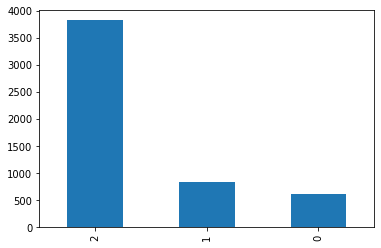

In [3]:
df['sentiment'].value_counts().plot(kind='bar')
plt.show()

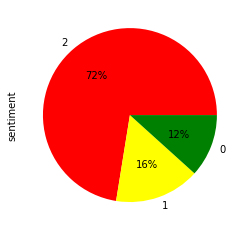

In [4]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

# Observations
The neutral sentiment is greater than negative 7 positive sentiment.It makes data imbalanced.
From the bar plot ,it is seen that sampled datasets of sentiment is imbalnced

# Data Pre-processing on raw data:
Before feeding the data into the model, we have to preprocess the text.
  * Convert all decontracted phrase into proper  english format  .In NLTK libraries ,"not" is stopwords . But "Not" is very important keyword for finding negative sentiment.
  * After that we neet to remove numbers and unwanted symbols, http links from text. 
  
Ref:# https://stackoverflow.com/a/47091490/4084039

In [5]:
def preprocess_data(df):
    # https://stackoverflow.com/a/47091490/4084039
    import re
    import nltk
    nltk.download('stopwords')
    from tqdm import tqdm
    import re

    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
    #Sorting data according to unique_hash in ascending order
    global sorted_data
    sorted_data=df.sort_values('unique_hash', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    
    sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(sorted_data['text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'html.parser').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance=(sno.stem(sentance.lower()))
        sentance = ' '.join(sno.stem(e.lower()) for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_text.append(sentance.strip())

    sorted_data['clean_data']=preprocessed_text
    #return sorted_data

In [6]:
preprocess_data(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iventura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 5279/5279 [00:20<00:00, 254.84it/s]


In [7]:
sorted_data['clean_data']=sorted_data['drug']+str(' ')+ sorted_data['clean_data']

In [8]:
sorted_data.tail()

,unique_hash,text,drug,sentiment,clean_data
5199,ffbe209ec31113070575e17a106a0f7de22fc191,"Fraser Cummings, MBChB, DPhil, University Hosp...",ct-p13,2,ct-p13 fraser cum mbchb dphil univers hospit s...
5088,ffc25661252261987b439c7ea3f30b82fcc26698,Kanva! It's so good to hear from you!!! Like s...,stelara,2,stelara kanva good hear like serious realli go...
4185,ffdc0367deb5dd0c53382ea00899b56cad1ef836,http://www.businesswire.com/news/hom...A2-Ocre...,ocrelizumab,0,ocrelizumab fda extend review ocrelizumab arti...
237,fffdb80f7a644eb083d37c8314e893b069970957,I am having my first infusion of Ocrelizumab n...,ocrelizumab,2,ocrelizumab first infus ocrelizumab next week
4444,fffe2ec07bb421754c5225f4b5bce4e2ca5b57ab,"I am new here, be gentle with me and forgive m...",fingolimod,2,fingolimod new gentl forgiv post wrong area tr...


## Pandas dataframe to markdown Table format

In [9]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    #writer.table_name = name
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()

# Splitting Training and Testing dataset {for testing purpose}

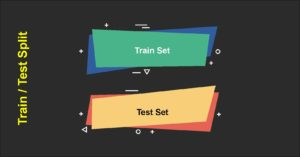

In [10]:
from sklearn.model_selection import train_test_split
x=sorted_data['clean_data']
y=sorted_data['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)
print('x_train=',x_train.shape,"x_test",x_test.shape)
print("y_train",y_train.shape,"y_test",y_test.shape)

x_train= (3695,) x_test (1584,)
y_train (3695,) y_test (1584,)


# [MultinomialNB Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)


 Here We are using MultinomialNB classifier for getting sentiment of text.First of all we are tunning Hypermeter alpha to get best results.
 
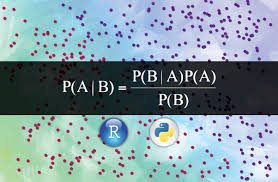


##  alpha_nb is function to calculate the alpha value for naive bayes

In [11]:
#  alpha_nb is function to calculate the alpha value for naive bayes
from sklearn.naive_bayes import MultinomialNB
def alpha_nb(X_train,y_train, My_List):
   
    alpha_value = list(filter(lambda x: x % 2 != 0, My_List))

    # empty list that will hold cv scores
    cv_scores = []
    
    # perform Time seris splitting  cross validation
    for i in alpha_value:
        nb_classifier = MultinomialNB(alpha= i, fit_prior=True)
        scores = cross_val_score(nb_classifier, X_train, y_train, cv=10, scoring='f1_macro')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha value
    global best_alpha_value
    best_alpha_value = alpha_value[MSE.index(min(MSE))]
    print('\nThe best value of alpha is %d.' % best_alpha_value)
  
      # plot misclassification error vs alpha 
    fig = plt.figure( facecolor='y', edgecolor='k',figsize=(15,8))
  
    plt.semilogx(alpha_value, MSE,'m*',linestyle='dashed', label='depthsize')
    plt.legend(loc='lower left')
    plt.grid()
    for xy in zip(alpha_value, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Error_Rate vs. alpha_Value')
    plt.xlabel('Number of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each alpha value is : ", np.round(MSE,3))
    
    
    
    
    return best_alpha_value

# Feature Extraction using [TFIDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Machine learning algorithms cannot work with raw text directly. Rather, the text must be converted into vectors of numbers.Text data requires special preparation before you can start using it for predictive modeling.After raw preprocessing the text,text words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).



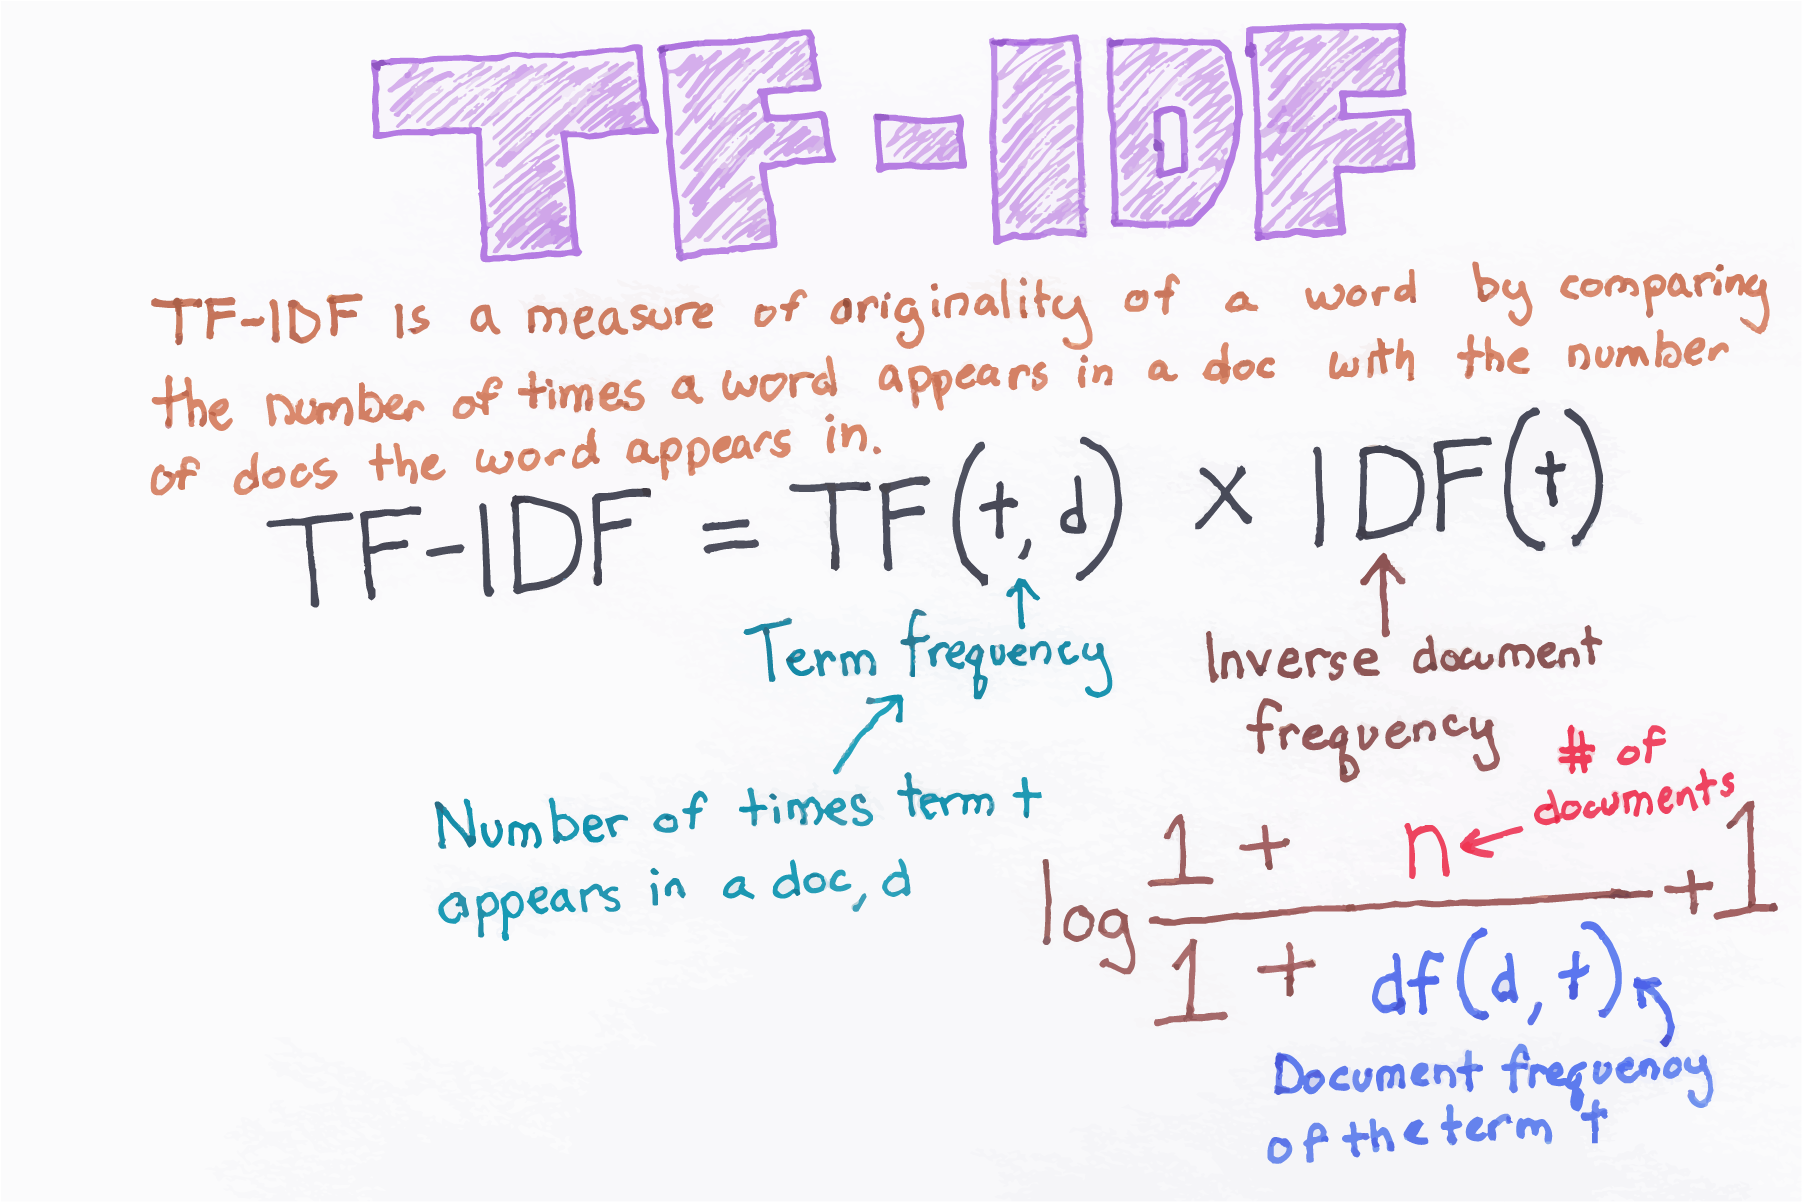  

In [12]:
tf_idf_vect = TfidfVectorizer( max_features=1000,ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(x_train.values.astype('U').ravel())
final_tf_idf.get_shape()

xtrain =  StandardScaler(with_mean=False).fit_transform(final_tf_idf )
print(xtrain.shape)

(3695, 1000)


In [13]:
final_tf_idf_test = tf_idf_vect.transform(x_test.values.astype('U').ravel())
final_tf_idf_test.get_shape()
xtest =  StandardScaler(with_mean=False).fit_transform(final_tf_idf_test )
print(xtest.shape)

(1584, 1000)


# [SMOTE](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/)
SMOTE is an oversampling technique that generates synthetic samples from the minority class. It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier

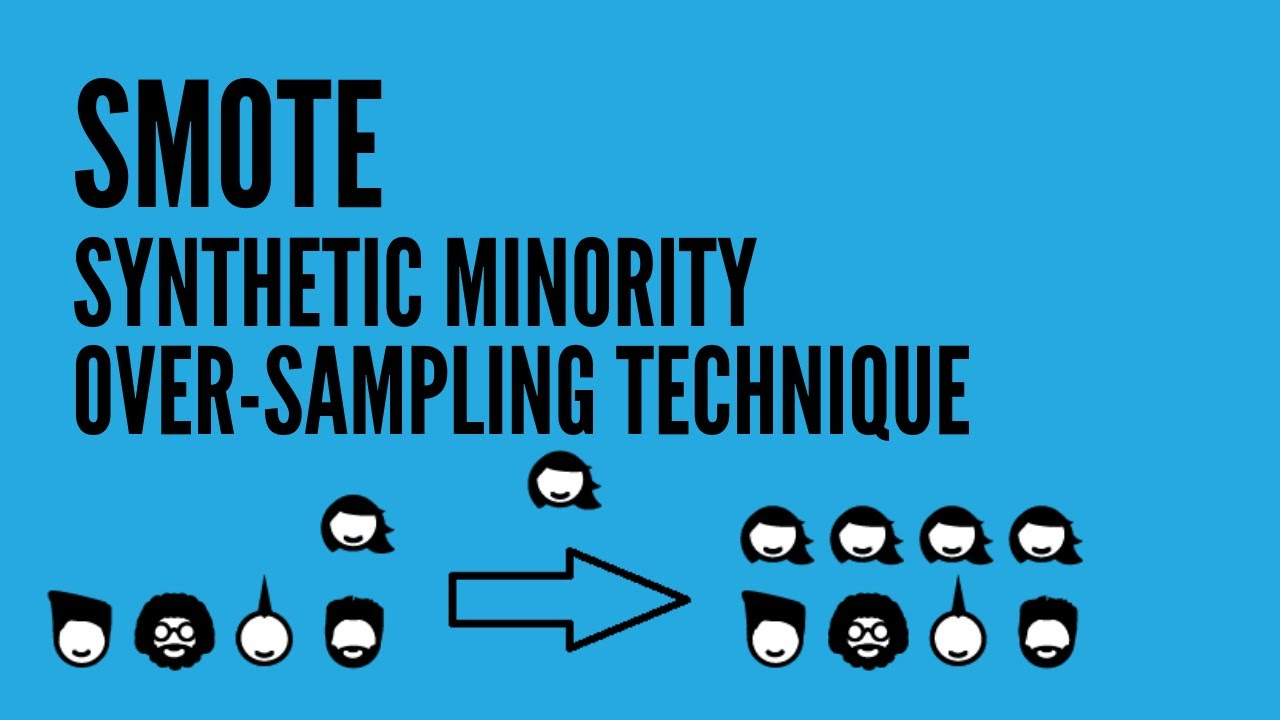 

In [14]:
#pip install imblearn
from imblearn.over_sampling import SMOTE
smt = SMOTE()
x1,y1 = smt.fit_sample(xtrain,y_train)
np.bincount(y1)

Using TensorFlow backend.


array([2660, 2660, 2660])

In [15]:
x2,y2 = smt.fit_sample(xtest,y_test)
np.bincount(y1)

array([2660, 2660, 2660])

In [16]:
xtrain =x1
xtest=x2
y_train=y1
y_test=y2

In [17]:
#y_train=y1.values.ravel()
#y_test=y2.values.ravel()


The best value of alpha is 3.


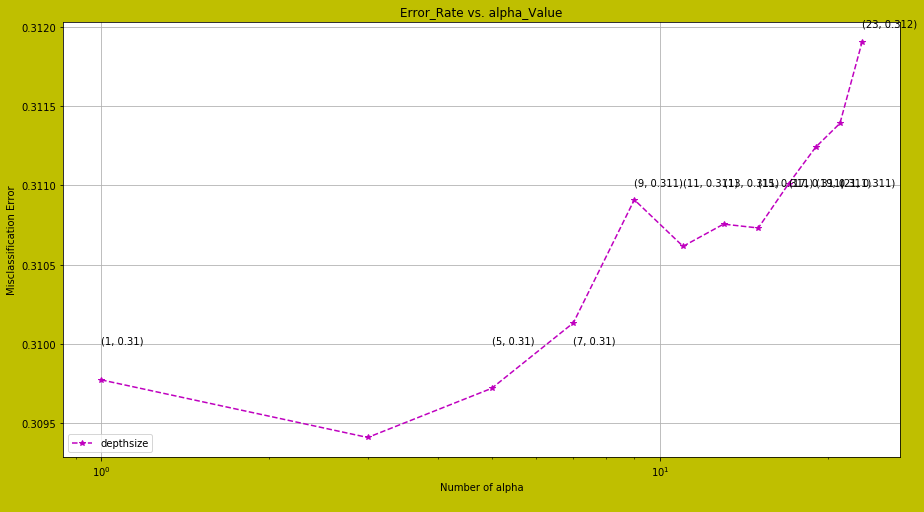

the misclassification error for each alpha value is :  [0.31  0.309 0.31  0.31  0.311 0.311 0.311 0.311 0.311 0.311 0.311 0.312]


In [18]:
My_List3 = list(range(0,25))

alphaNB = alpha_nb(xtrain ,y_train,My_List3)

In [19]:
C11 = np.logspace(0, 4, 10)
print(C11)

[1.00000000e+00 2.78255940e+00 7.74263683e+00 2.15443469e+01
 5.99484250e+01 1.66810054e+02 4.64158883e+02 1.29154967e+03
 3.59381366e+03 1.00000000e+04]


In [20]:
hp1=dict(alpha=C11)
nb3 =GridSearchCV(MultinomialNB(), hp1,cv=10,n_jobs=-1)
nb3.fit(xtrain ,y_train)

prediction3 = nb3.predict(xtest)

In [21]:

#Training accuracy and training error
training_score=nb3.score(xtrain ,y_train)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.7142857142857143
training error is = 0.2857142857142857


In [22]:

# Testing Accuracy and testing error for Naive Bayes model

Testing_score=round(accuracy_score(y_test ,prediction3),5)
print("Accuracy for Naive Bayes model with TF-IDF is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for Naive Bayes  model with TF-IDF is = ",Testing_error)

Accuracy for Naive Bayes model with TF-IDF is =  0.53505
Testing error for Naive Bayes  model with TF-IDF is =  0.46495


In [23]:
F1_score = round(f1_score(y_test ,prediction3,average='macro'),5)*100
recall = round(recall_score(y_test,prediction3,average='macro'),5)*100
precision = round(precision_score(y_test ,prediction3,average='macro'),5)*100

In [24]:
print(F1_score)

52.449999999999996


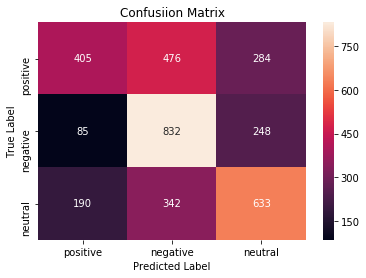

In [25]:
cm = confusion_matrix(y_test ,prediction3)
label = [ 'positive','negative','neutral']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
prediction33=prediction3.tolist()
print(prediction33.count(1))
print(prediction33.count(0))
print(prediction33.count(2))

1650
680
1165


# Train and test Datasets

In [27]:
x_train=x
y_train=y

In [28]:
df_test=pd.read_csv('test.csv')
df_test.head()

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara


# Pre processing Test

In [29]:
preprocess_data(df_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iventura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 2924/2924 [00:13<00:00, 213.98it/s]


In [30]:
test_data=sorted_data

In [31]:
test_data['clean_data']=test_data['drug']+str(' ')+ test_data['clean_data']

In [32]:
x_test=test_data['clean_data']
x_test.tail()

802    entyvio good luck ucfireman current fight insu...
773    gilenya sara decid return school full time sch...
291    opdivo nov wrote husband stage four nslc no cu...
864    ocrelizumab appear differ monoclon antibodi de...
844                     durvalumab durvalumab twin crack
Name: clean_data, dtype: object

In [33]:
tf_idf_vect = TfidfVectorizer( max_features=1000,ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(x_train.values.astype('U').ravel())
final_tf_idf.get_shape()

xtrain =  StandardScaler(with_mean=False).fit_transform(final_tf_idf )
print(xtrain.shape)

(5279, 1000)


In [34]:
final_tf_idf_test = tf_idf_vect.transform(x_test.values.astype('U').ravel())
final_tf_idf_test.get_shape()
xtest =  StandardScaler(with_mean=False).fit_transform(final_tf_idf_test )
print(xtest.shape)

(2924, 1000)


In [35]:
test_data['sentiment']=0

In [36]:
submission = pd.read_csv('samplesubmission.csv')
print(submission.shape)
print(test_data.shape)
#submission=submission[0:len(test)]
submission['unique_hash']= test_data['unique_hash']
submission['sentiment'] = test_data['sentiment']
print(submission.shape)

(2924, 2)
(2924, 5)
(2924, 2)


In [37]:
xtrain,y_train = smt.fit_sample(xtrain,y_train)
np.bincount(y_train)

array([3825, 3825, 3825])

In [38]:
#Best lambda and best penalty

hp1=dict(alpha=C11)
nb3 =GridSearchCV(MultinomialNB(), hp1,cv=10,n_jobs=-1)
%time nb3.fit(xtrain ,y_train)

prediction4 = nb3.predict(xtest)

CPU times: user 341 ms, sys: 34.5 ms, total: 376 ms
Wall time: 498 ms


In [39]:

#Training accuracy and training error
training_score=nb3.score(xtrain ,y_train)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.6845315904139434
training error is = 0.3154684095860566


In [40]:
submission['sentiment'][0:len(test_data)] = prediction4
#submission['cc_cons'][len(test):len(submission)] =median(pred)
submission.to_csv('submit_file_TFIDF_NB.csv',index=False)

In [41]:
senti_prediction_NB=submission['sentiment']
submission['sentiment'].value_counts()

2    1458
1    1038
0     428
Name: sentiment, dtype: int64

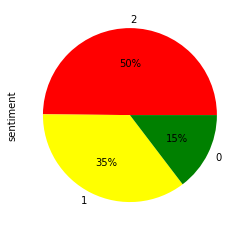

In [42]:
submission['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

# Save the result🙂

In [43]:
import pickle
pickle_out = open("senti_prediction_NB.pickle","wb")
pickle.dump(senti_prediction_NB, pickle_out)
pickle_out.close()

In [44]:
import pickle
import pandas as pd
infile = open("senti_prediction.pickle",'rb')
data1 = pickle.load(infile)
infile.close()  

In [45]:
z=data1.value_counts()
print(z)

2    2889
0      21
1      14
Name: sentiment, dtype: int64


In [46]:
#data1.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [47]:
filename = 'senti_prediction_NB.pickle'
with open(filename, 'rb') as f:
    classification_dict = pickle.load(f)

That's all folks 🙂! Now you can try your datasets and play around it🎆🎆🎆. Enjoy Machine Learning😃